In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("taxi_weather.csv")
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,distance_traveled_km,week_day
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,3.13,0.50,0.0,0,72,57,17.231137,0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,9.84,0.00,0.0,0,30,20,246.295936,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,4.92,0.07,0.0,0,83,67,55.251875,3
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,4.92,0.22,0.0,0,71,54,38.152003,5
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,4.47,0.00,0.0,0,61,44,74.122374,1


Create two features from the last project, distance and time of day

In [3]:
from sklearn.metrics.pairwise import haversine_distances

# function for distance feature
def hav_distance(lon1, lat1, lon2, lat2):
    # use sklearn's haversine function and multiply by Earth's radius to get distance in km
    return haversine_distances([[lon1, lat1], [lon2, lat2]])[0][1] * 6371000/1000

df['distance_traveled_km'] = df.apply(lambda x: hav_distance(x['pickup_longitude'], x['pickup_latitude'], 
                                                            x['dropoff_longitude'], x['dropoff_latitude']), axis=1)

# function for pickup_hour feature
def time_parse(time_str):
    time = time_str.split()[1]
    return int(time.split(":")[0])

df['pickup_hour'] = df.apply(lambda x: time_parse(x['pickup_datetime']), axis=1)

Create a feature for a bucket that the distance would fall into

In [4]:
df['distance_bin'] = pd.cut(df['fare_amount'], bins = list(range(0, 300, 75))).astype(str)

Drop the nans from the dataframe

In [5]:
df = df.dropna(axis='rows')
print('New number of observations: %d' % len(df))

New number of observations: 990845


Some of the fares also make no sense, so fix that too. Since as of 2018, the lowest base fee for a taxi ride in NYC is $2.50, I'll drop observations with fare_amount below 1.5

Also, the 99.9th percentile is less than 58, so it looks safe to just cut out values >= 60

In [6]:
df = df[df['fare_amount'] > 1.5]
df = df[df['fare_amount'] < 60]

Some of the observations are too high to make sense, so take out all of the rows where the distance traveled is above the 95th percentile, then also take out all of the rows where the distances is 0

In [7]:
df = df[df['distance_traveled_km'] <= df['distance_traveled_km'].quantile(.95)]
df = df[df['distance_traveled_km'] > 0]
df['distance_traveled_km'].describe()

count    910658.000000
mean        106.790090
std          93.896455
min           0.000214
25%          42.398428
50%          79.854190
75%         140.872712
max         599.238398
Name: distance_traveled_km, dtype: float64

In [8]:
df['distance_traveled_km'].value_counts()

0.006371      19
0.012742      12
0.012742       8
0.025484       7
0.019113       7
              ..
120.973732     1
83.364167      1
94.942996      1
18.497318      1
117.810997     1
Name: distance_traveled_km, Length: 910563, dtype: int64

A lot of the coordinates are wrong and would mess up the analysis, so take those out of the df

After checking the coordinates against a map of NYC, I've determined that reasonable longitude bounds are [-74.20, -73.25] which reasonable latitude bounds are [40.95, 40.50].

In [9]:
# lower bound for latitude
df = df[df['pickup_latitude'] >= 40.5]
df = df[df['dropoff_latitude'] >= 40.5]

# upper bound for latitude
df = df[df['pickup_latitude'] <= 40.95]
df = df[df['dropoff_latitude'] <= 40.95]

# upper bound for longitude
df = df[df['pickup_longitude'] <= -73.75]
df = df[df['dropoff_longitude'] <= -73.75]

# lower bound for longitude
df = df[df['pickup_longitude'] >= -74.2]
df = df[df['dropoff_longitude'] >= -74.2]

Convert the lattitudes and longitudes to np arrays of x and y so that I can form a grid.

Divide the area up into grid of 100 by 100 rectangles

In [10]:
y = np.concatenate([df['pickup_latitude'].to_numpy(), df['dropoff_latitude'].to_numpy()])
x = np.concatenate([df['pickup_longitude'].to_numpy(), df['dropoff_longitude'].to_numpy()])

bottom_left, bottom_right = (x.min(), y.min()), (x.max(), y.min())
top_left, top_right = (x.min(), y.max()), (x.max(), y.max())

cols = np.linspace(bottom_left[0], bottom_right[0], num=100)
rows = np.linspace(bottom_left[1], top_left[1], num=100)


# create columns for each observation's dropoff and pickup places in the grid
df['pick_col'] = np.searchsorted(cols, df['pickup_longitude'])
df['drop_col'] = np.searchsorted(cols, df['dropoff_longitude'])

df['pick_row'] = np.searchsorted(rows, df['pickup_latitude'])
df['drop_row'] = np.searchsorted(rows, df['dropoff_latitude'])

Create a 2d histogram to visualize the densities of pickup and dropoff points

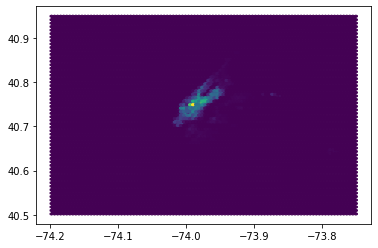

In [11]:
plt.hexbin(x,y)
plt.show()

In [12]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,DATE,AWND,PRCP,...,TMAX,TMIN,distance_traveled_km,week_day,pickup_hour,distance_bin,pick_col,drop_col,pick_row,drop_row
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,3.13,0.50,...,72,57,17.231137,0,17,"(0.0, 75.0]",79,79,49,47
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,9.84,0.00,...,30,20,246.295936,1,16,"(0.0, 75.0]",41,49,47,62
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,4.92,0.07,...,83,67,55.251875,3,0,"(0.0, 75.0]",48,46,58,55
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,4.92,0.22,...,71,54,38.152003,5,4,"(0.0, 75.0]",47,46,52,57
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,4.47,0.00,...,61,44,74.122374,1,7,"(0.0, 75.0]",51,54,59,63


try plotting a subsection of these points since it seems like most of the boxes are relatively unused, effectively zooming in

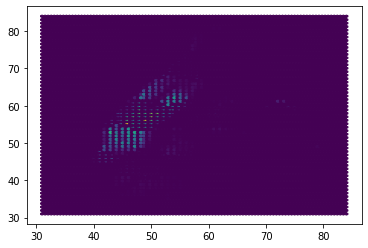

In [13]:
x_corr = np.concatenate([df['pick_col'].to_numpy(), df['drop_col'].to_numpy()])
y_corr = np.concatenate([df['pick_row'].to_numpy(), df['drop_row'].to_numpy()])

x_indexes = np.where((x_corr <= 30) | (x_corr >= 85))
y_indexes = np.where((y_corr <= 30) | (y_corr >= 85))

# get the unique index positions of the observations that don't fit to filter them out
indexes = np.unique(np.concatenate([x_indexes, y_indexes], axis=1))

# filter the x and y coordinates and then plot
x_fil = np.delete(x_corr, indexes)
y_fil = np.delete(y_corr, indexes)

plt.hexbin(x_fil,y_fil)
plt.show()

Now find the 100 most densely populated (x, y) pairs in the grid 

In [14]:
import collections

pair_occurances = collections.defaultdict(int)
for n in range(len(x_corr)):
    #pair = x_corr[n], y_corr[n]
    pair_occurances[x_corr[n], y_corr[n]] +=1

# sort by descending order of occurances 
pair_occurances = collections.OrderedDict(sorted(pair_occurances.items(), key=lambda t: t[1], reverse=True))
# convert to list
pair_occurances = [list(n) for n in list(pair_occurances.keys())]
# get 100 most common pairs
top_100 = pair_occurances[:100]

Now that I have the 100 most common pairs, find all of the observations that fit inside them and use those for the analysis

In [15]:
# first reset the indexes so that I can iterate through the rows
df = df.reset_index(drop=True)

df_top = [[] for i in range(100)]

for n in range(len(df)):
    if [df['pick_col'][n], df['pick_row'][n]] in top_100:
        df_top[top_100.index([df['pick_col'][n], df['pick_row'][n]])].append(n)
    if [df['drop_col'][n], df['drop_row'][n]] in top_100:
        df_top[top_100.index([df['drop_col'][n], df['drop_row'][n]])].append(n)

Visualize the distribution of rain and snow

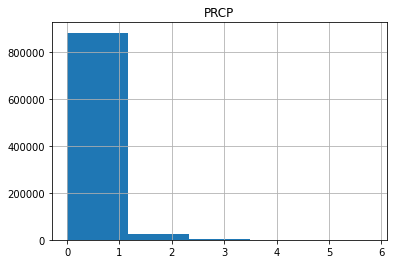

In [16]:
rain = df.hist(column='PRCP', bins=5)

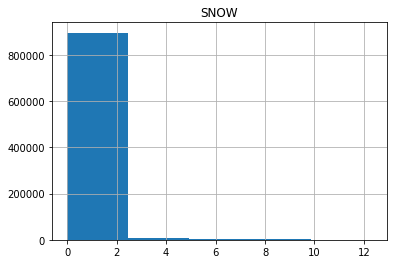

In [17]:
snow = df.hist(column='SNOW', bins=5)

According the NOAA, snowfall accumulating to 6" or more in depth in 24 hours or less is considered heavy snowfall, so that will be my cutoff for heavy snow. Also according to NOAA, moderate rainfall measures 0.10 to 0.30 inches of rain per hour and heavy rainfall is more than 0.30 inches of rain per hour. Since this data is over a 24 hour period, I'll say that 0.15 * 24 inches of rain will qualify as heavy rain.

To try and control for distance, I've segmented the observations by distance and try to find the average 

In [18]:
snow_dif = []
rain_dif = []

for n in df_top:

    df_i = df[df.index.isin(n)]

    df_snow = df_i[df_i['SNOW'] >= 6]
    df_ns = df_i[df_i['SNOW'] < 6]

    df_rain = df_i[df_i['PRCP'] >= (0.15 * 24)]
    df_nr = df_i[df_i['PRCP'] < (0.15 * 24)]

    # to account for distance, find averages for each of the distance buckets
    snow_average = df_snow[df_snow['distance_traveled_km'] < 30]['fare_amount'].mean()
    ns_average = df_ns[df_ns['distance_traveled_km'] < 30]['fare_amount'].mean()
    s_dif = ((snow_average - ns_average) / ns_average * 100.0)
    
    snow_average = df_snow[(df_snow['distance_traveled_km'] < 50) & (df_snow['distance_traveled_km'] > 30)]['fare_amount'].mean()
    ns_average = df_ns[(df_ns['distance_traveled_km'] < 50) & (df_ns['distance_traveled_km'] > 30)]['fare_amount'].mean()
    s_dif += ((snow_average - ns_average) / ns_average * 100.0)

    snow_average = df_snow[(df_snow['distance_traveled_km'] < 100) & (df_snow['distance_traveled_km'] > 50)]['fare_amount'].mean()
    ns_average = df_ns[(df_ns['distance_traveled_km'] < 100) & (df_ns['distance_traveled_km'] > 50)]['fare_amount'].mean()
    s_dif += ((snow_average - ns_average) / ns_average * 100.0)
    
    snow_average += df_snow[df_snow['distance_traveled_km'] > 100]['fare_amount'].mean()
    ns_average += df_ns[df_ns['distance_traveled_km'] > 100]['fare_amount'].mean()
    s_dif += ((snow_average - ns_average) / ns_average * 100.0)
    
    

    rain_average = df_rain[df_rain['distance_traveled_km'] < 30]['fare_amount'].mean()
    nr_average = df_nr[df_nr['distance_traveled_km'] < 30]['fare_amount'].mean()
    r_dif = ((rain_average - nr_average) / nr_average * 100.0)

    rain_average = df_rain[(df_rain['distance_traveled_km'] < 50) & (df_rain['distance_traveled_km'] > 30)]['fare_amount'].mean()
    nr_average = df_nr[(df_nr['distance_traveled_km'] < 50) & (df_nr['distance_traveled_km'] > 30)]['fare_amount'].mean()
    r_dif += ((rain_average - nr_average) / nr_average * 100.0)

    rain_average = df_rain[(df_rain['distance_traveled_km'] < 100) & (df_rain['distance_traveled_km'] > 50)]['fare_amount'].mean()
    nr_average = df_nr[(df_nr['distance_traveled_km'] < 100) & (df_nr['distance_traveled_km'] > 50)]['fare_amount'].mean()
    r_dif += ((rain_average - nr_average) / nr_average * 100.0)
    
    rain_average = df_snow[df_snow['distance_traveled_km'] > 100]['fare_amount'].mean()
    nr_average = df_ns[df_ns['distance_traveled_km'] > 100]['fare_amount'].mean()
    r_dif += ((rain_average - nr_average) / nr_average * 100.0)
    
    snow_dif.append(s_dif/4)
    rain_dif.append(r_dif/4)

now that we have 2 lists of the differences for each geographic zone, create a dataframe where the columns are the percent differences due to rain and snow and the rows are each of the zones

In [19]:
df_zones = pd.DataFrame({'Snow': snow_dif, 'Rain': rain_dif})

# start the index from 1
df_zones.index = np.arange(1, len(df_zones) + 1)

df_zones.to_csv('submission.csv')

In [20]:
df_zones

,Snow,Rain
1,-5.420136,-3.902233
2,-4.945944,-3.765901
3,1.717089,13.405614
4,-3.908047,-1.184470
5,-5.238583,31.510532
...,...,...
96,-7.478617,-15.673104
97,-1.443182,2.443101
98,-12.328111,NaN
99,-6.431143,-3.018862
